<a href="https://colab.research.google.com/github/kimjaehwankimjaehwan/china/blob/main/comparing_tree_based_models_with_covid_19_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import AdaBoostClassifier as ABC
from sklearn.ensemble import GradientBoostingClassifier as GBM
import xgboost as xgb

In [4]:
data = pd.read_csv("/content/drive/MyDrive/중국/COVID19/Covid Data.csv", sep = "," )


In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
data.shape

(1048575, 21)

* First look to data

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
USMER,1048575.0,1.632194,0.482208,1.0,1.0,2.0,2.0,2.0
MEDICAL_UNIT,1048575.0,8.980565,3.723278,1.0,4.0,12.0,12.0,13.0
SEX,1048575.0,1.499259,0.500000,1.0,1.0,1.0,2.0,2.0
PATIENT_TYPE,1048575.0,1.190765,0.392904,1.0,1.0,1.0,1.0,2.0
INTUBED,1048575.0,79.522875,36.868886,1.0,97.0,97.0,97.0,99.0
PNEUMONIA,1048575.0,3.346831,11.912881,1.0,2.0,2.0,2.0,99.0
AGE,1048575.0,41.794102,16.907389,0.0,30.0,40.0,53.0,121.0
PREGNANT,1048575.0,49.765585,47.510733,1.0,2.0,97.0,97.0,98.0
DIABETES,1048575.0,2.186404,5.424242,1.0,2.0,2.0,2.0,98.0
COPD,1048575.0,2.260569,5.132258,1.0,2.0,2.0,2.0,98.0


**Here if a person ,who dead because of Covid 19, i flagged as 1. Thus IsDead is our dependent variable anymore**

In [8]:
data['IsDead'] = data['DATE_DIED'].apply(lambda x: 1 if x == '9999-99-99' else 0)
data = data.drop(["DATE_DIED"], axis = 1)

In [9]:
data["IsDead"].value_counts()

,count
IsDead,
1,971633
0,76942


**In current situation; our data looks unbalanced. Thus we will make undersampling to our dataset**

* Train Test Split Process

In [10]:
y = data["IsDead"]
X = data.drop(["IsDead"] , axis =1 )
X= pd.DataFrame(X)
y = pd.DataFrame(y)
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42, train_size = 0.8)

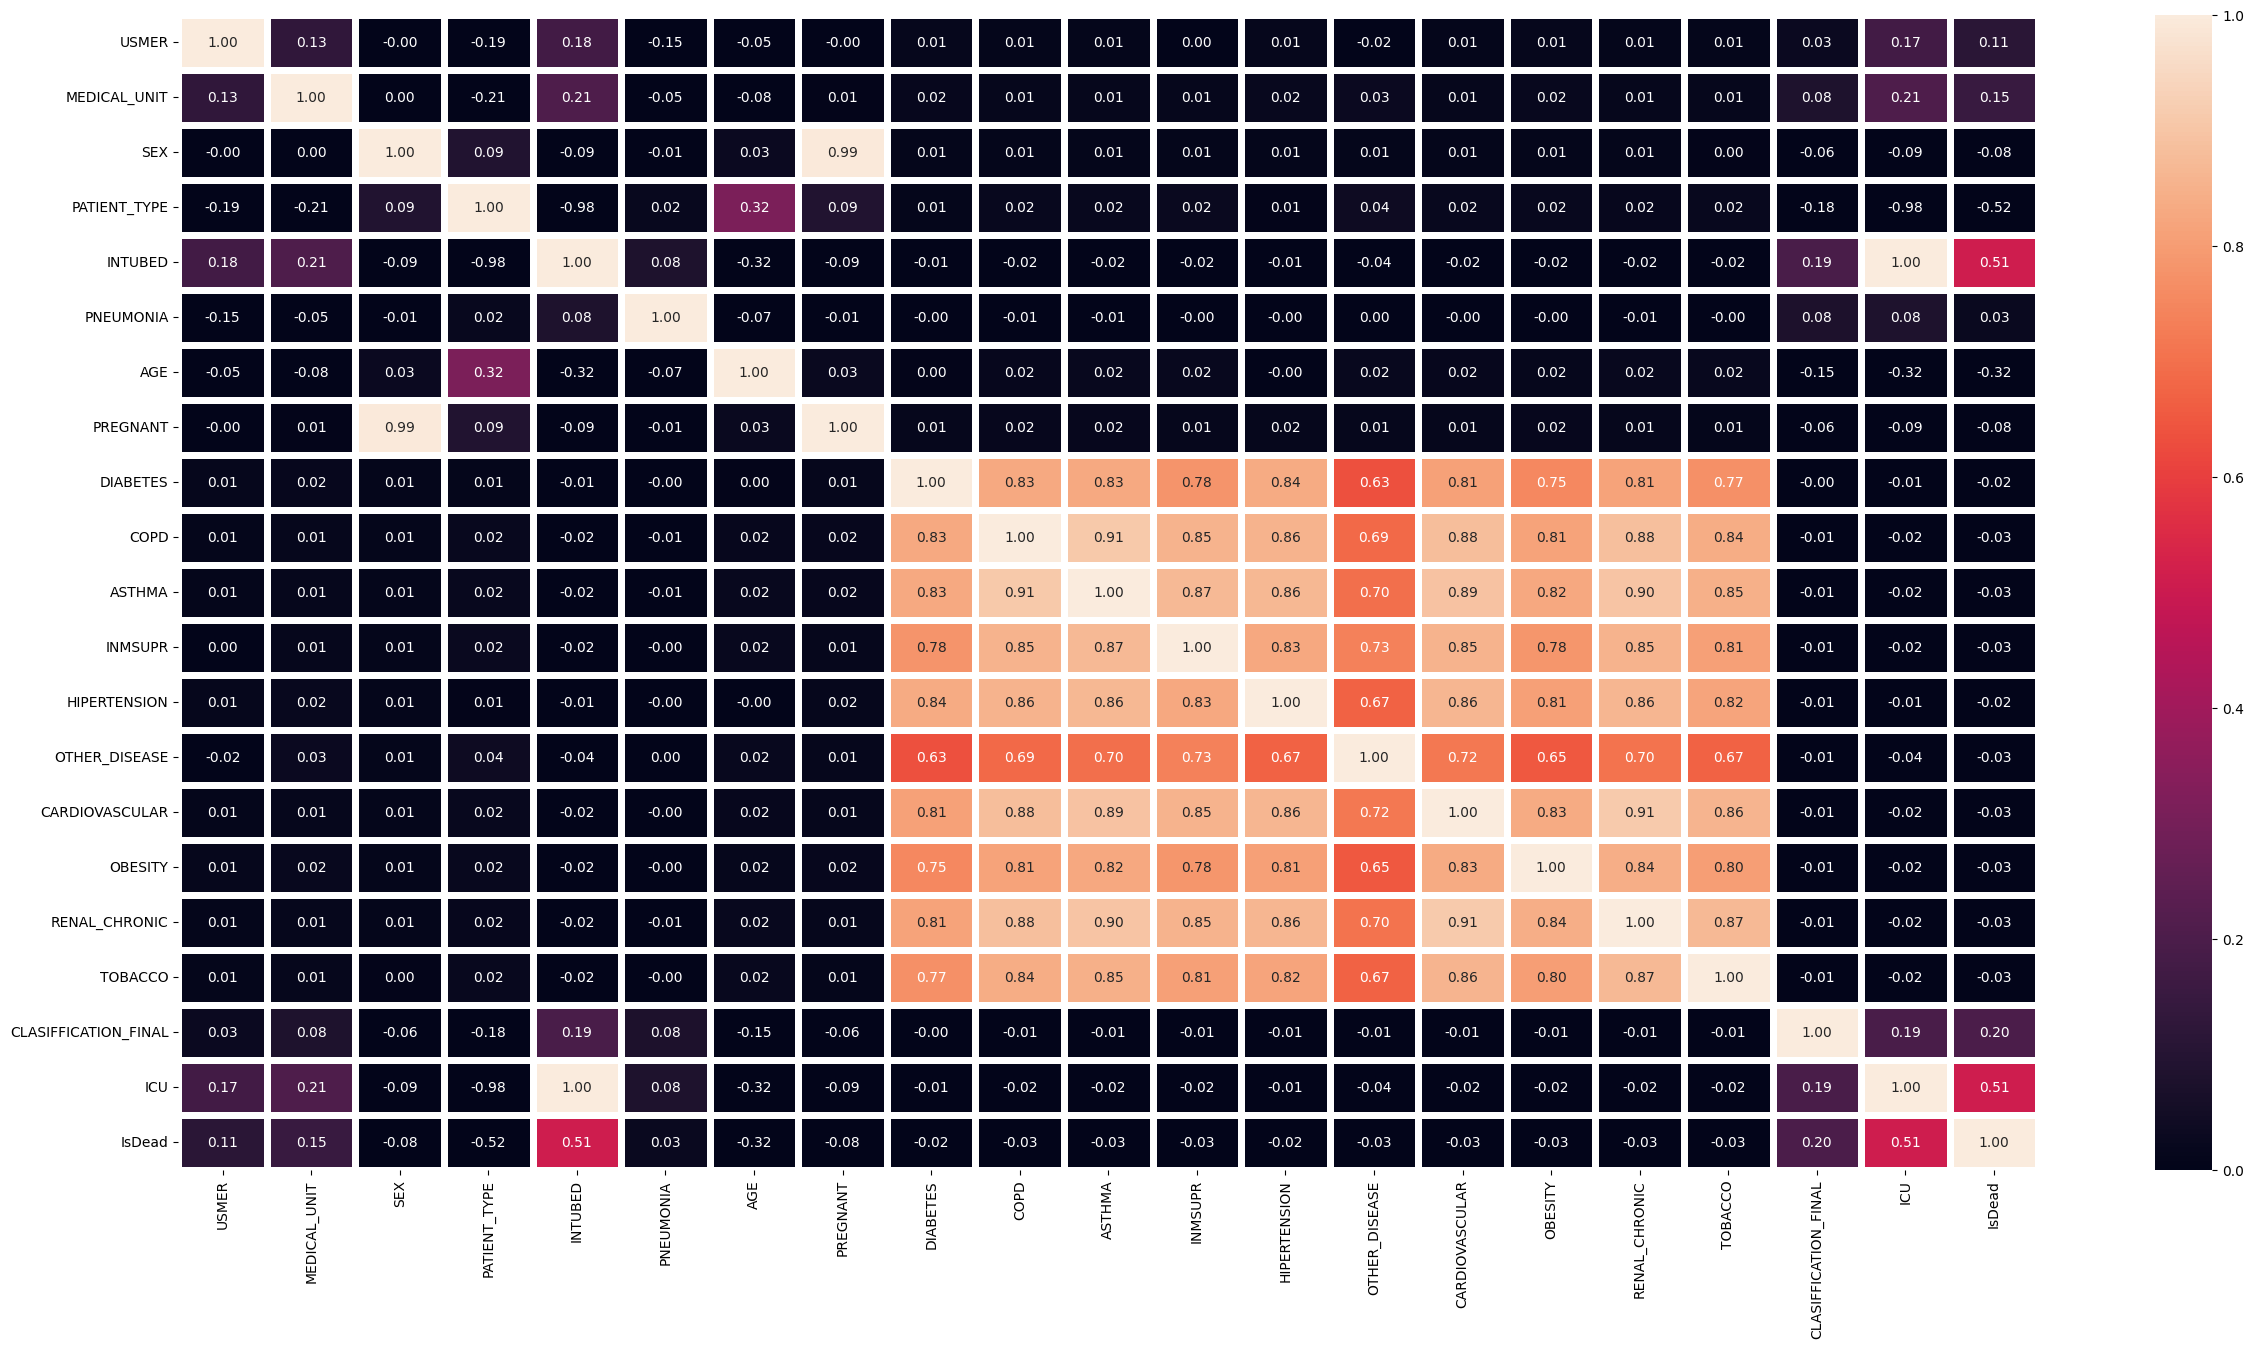

In [11]:
plt.figure(figsize=(30, 15))
sns.heatmap(data.corr(), vmin=0, vmax=1, cbar = True,
            linewidths = 5,
            annot = True,
            fmt=".2f")
plt.show()

In [12]:
# %pip install feature_engine
# !pip install scikit-learn==1.4.2


In [13]:
from feature_engine.selection import DropCorrelatedFeatures
corrolated = DropCorrelatedFeatures(method="pearson", threshold=0.85)
corrolated.fit(X_train)


DropCorrelatedFeatures(threshold=0.85)

In [14]:
print(corrolated.features_to_drop_)
print(corrolated.correlated_feature_sets_)

['CARDIOVASCULAR', 'COPD', 'HIPERTENSION', 'INMSUPR', 'RENAL_CHRONIC', 'INTUBED', 'PATIENT_TYPE', 'SEX']
[{'INMSUPR', 'RENAL_CHRONIC', 'HIPERTENSION', 'CARDIOVASCULAR', 'ASTHMA', 'COPD'}, {'INTUBED', 'ICU', 'PATIENT_TYPE'}, {'SEX', 'PREGNANT'}]


**Here some corrolated features exist. We will drop them from our dataset with using Feature Engine**

* Drop corrolated features from Dataset

In [15]:
X_train = corrolated.transform(X_train)
X_test= corrolated.transform(X_test)

In [16]:
print('X_train shape before undersampling: ' + str(X_train.shape))
print('y_train shape before undersampling: ' + str(y_train.shape))

X_train shape before undersampling: (838860, 12)
y_train shape before undersampling: (838860, 1)


* Undersampling

In [17]:
##%pip install imblearn
from imblearn.under_sampling import RandomUnderSampler
under_sampler = RandomUnderSampler(
    sampling_strategy = 'auto',
    random_state = 42,
    replacement = True)
X_train, y_train = under_sampler.fit_resample(X_train,y_train)

In [18]:
print('X_train shape after undersampling: ' + str(X_train.shape))
print("X_train shape after undersampling: " + str(y_train.shape))

X_train shape after undersampling: (123404, 12)
X_train shape after undersampling: (123404, 1)


Decision Tree Classifier

1. Decision Tree Classifier Basic

In [19]:

dcs_basic = DecisionTreeClassifier(random_state = 42,splitter = 'best', criterion= "gini")
dcs_basic.fit(X_train, y_train)
y_pred_dcs_basic =  dcs_basic.predict(X_test)
print(classification_report(y_test, y_pred_dcs_basic))

              precision    recall  f1-score   support

           0       0.34      0.91      0.50     15240
           1       0.99      0.86      0.92    194475

    accuracy                           0.87    209715
   macro avg       0.67      0.89      0.71    209715
weighted avg       0.95      0.87      0.89    209715



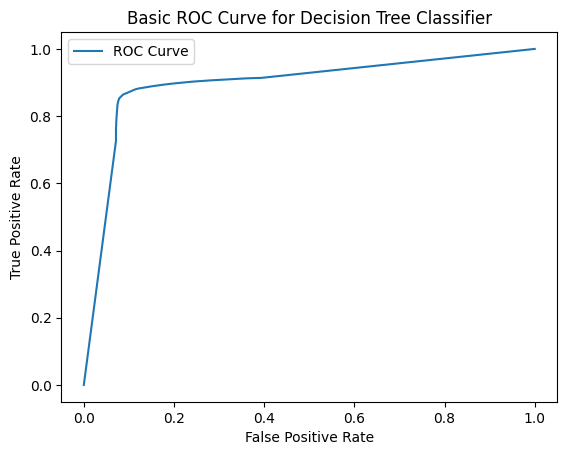

In [20]:
from sklearn.metrics import roc_curve, roc_auc_score
y_prob = dcs_basic.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Basic ROC Curve for Decision Tree Classifier')
plt.legend()
plt.show()

In [21]:
auc_score = roc_auc_score(y_test, y_prob)
print(f'Basic AUC Score for Decision Tree Classifier: {auc_score}')

Basic AUC Score for Decision Tree Classifier: 0.8949673444454229


We got 0.89496 AUC Score for our model

2. Hyperparameter Optimization for Decision Tree Classifier

In [22]:
dtc_grid_params = {
    "max_depth" : [ 2,3,4,5,6,8],
    "min_samples_split" : [2,3,4,5],
    "min_samples_leaf" : [1,5,10,25]
}

In [23]:
"""dtc_grid_finals = GridSearchCV(dcs_basic,dtc_grid_params, cv = 10, n_jobs = -2)
dtc_grid_finals.fit(X_train,y_train)
dtc_grid_finals.best_params_
"""

'dtc_grid_finals = GridSearchCV(dcs_basic,dtc_grid_params, cv = 10, n_jobs = -2)\ndtc_grid_finals.fit(X_train,y_train)\ndtc_grid_finals.best_params_\n'

Here for computational cost; i didn't run this code again; to here and future algorithms i won't run this param grid because of this reason.

In [24]:
dtc_grid_finals = DecisionTreeClassifier(random_state= 42, max_depth= 8 ,min_samples_leaf= 1 , min_samples_split = 3)
dtc_grid_finals.fit(X_train,y_train)
y_pred_dtc_grid_finals = dtc_grid_finals.predict(X_test)
print(classification_report(y_test, y_pred_dtc_grid_finals))

              precision    recall  f1-score   support

           0       0.37      0.95      0.53     15240
           1       1.00      0.87      0.93    194475

    accuracy                           0.88    209715
   macro avg       0.68      0.91      0.73    209715
weighted avg       0.95      0.88      0.90    209715



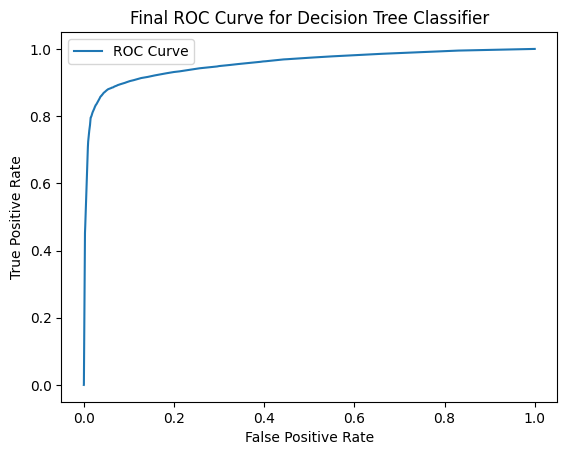

In [25]:
y_prob_final = dtc_grid_finals.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_final)
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Final ROC Curve for Decision Tree Classifier')
plt.legend()
plt.show()

In [26]:
auc_score = roc_auc_score(y_test, y_prob_final)
print(f'Final AUC Score for Decision Tree Classifier: {auc_score}')

Final AUC Score for Decision Tree Classifier: 0.9559965377206753


**We started with 0.89496 AUC score and increased our performance to 0.95599 with hyper parameter optimization!**

* Random Forest Classifier

1.  Random Forest Classifier Basic

In [27]:
from sklearn.ensemble import RandomForestClassifier as RFC
RFC_basic = RFC(random_state = 42, n_jobs= -2)
RFC_basic.fit(X_train, y_train)
RFC_basic_y_pred = RFC_basic.predict(X_test)
print(classification_report(y_test,RFC_basic_y_pred))

              precision    recall  f1-score   support

           0       0.37      0.93      0.52     15240
           1       0.99      0.87      0.93    194475

    accuracy                           0.88    209715
   macro avg       0.68      0.90      0.73    209715
weighted avg       0.95      0.88      0.90    209715



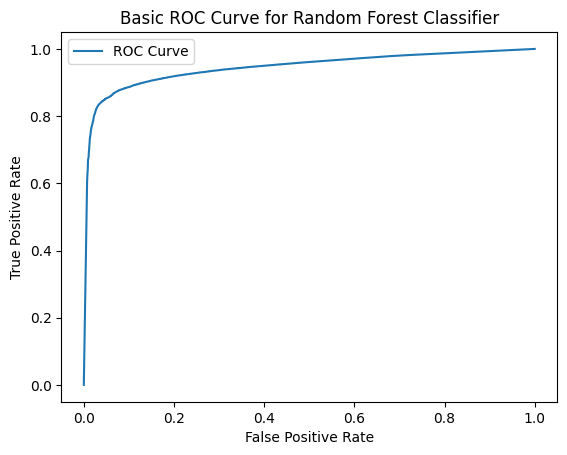

In [28]:
y_prob_rfc_basic = RFC_basic.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_rfc_basic)
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Basic ROC Curve for Random Forest Classifier')
plt.legend()
plt.show()

In [29]:
auc_score = roc_auc_score(y_test, y_prob_rfc_basic)
print(f'Basic AUC Score for Random Forest Classifier: {auc_score}')

Basic AUC Score for Random Forest Classifier: 0.9444328026293282


In Random Forest model we have 0.94443 AUC Score without hyper parameter optimization!

2. Hyper Parameter Optimization for Random Forest Classifier  

In [30]:
"""
rfc_params = {
    "n_estimators" : [100,250,500,1000],
    "max_depth" : [3,5,6,8],
    "min_samples_split" : [2,3,5],
    "min_samples_leaf" : [1,2,3,4]
}
rf_grid = GridSearchCV(RFC_basic, rfc_params, cv = 10 )
rf_grid.fit(X_train,y_train)
rf_grid.best_params_
"""

'\nrfc_params = {\n    "n_estimators" : [100,250,500,1000],\n    "max_depth" : [3,5,6,8],\n    "min_samples_split" : [2,3,5],\n    "min_samples_leaf" : [1,2,3,4]   \n}\nrf_grid = GridSearchCV(RFC_basic, rfc_params, cv = 10 )\nrf_grid.fit(X_train,y_train)\nrf_grid.best_params_\n'

In [31]:
rfc_grid_final = RFC( random_state= 42, criterion= "gini", max_depth= 8 , min_samples_leaf= 8 , min_samples_split= 5,n_estimators= 250)
rfc_grid_final.fit(X_train,y_train)
RFC_final_y_pred = rfc_grid_final.predict(X_test)
print(classification_report(y_test,RFC_final_y_pred))

              precision    recall  f1-score   support

           0       0.37      0.95      0.53     15240
           1       1.00      0.87      0.93    194475

    accuracy                           0.88    209715
   macro avg       0.68      0.91      0.73    209715
weighted avg       0.95      0.88      0.90    209715



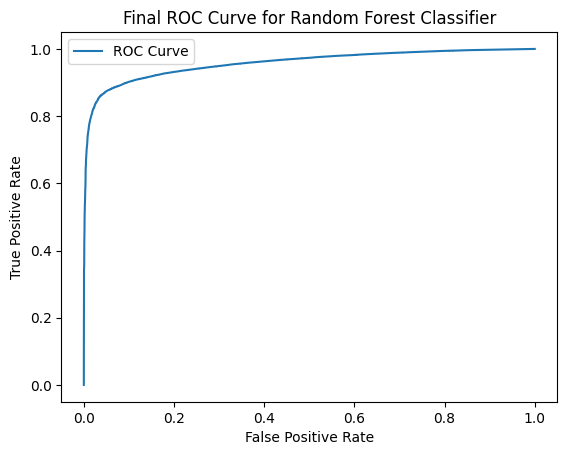

In [32]:
y_prob_rfc_final = rfc_grid_final.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_rfc_final)
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Final ROC Curve for Random Forest Classifier')
plt.legend()
plt.show()

In [33]:
auc_score = roc_auc_score(y_test, y_prob_rfc_final)
print(f'Final AUC Score for Random Forest Classifier: {auc_score}')

Final AUC Score for Random Forest Classifier: 0.9575287112925


We increased our AUC Score in Random Forest Algorithm with Hyper Parameter Tuning either! Now we have 0.95752 AUC Score!

* Adaboost Classifier Algorithm

1.  Adaboost Classifier Basic

In [34]:
from sklearn.ensemble import AdaBoostClassifier as ABC
abc_basic= ABC(random_state = 42)
abc_basic  = abc_basic.fit(X_train,y_train)
abc_basic_y_pred = abc_basic.predict(X_test)
print(classification_report(y_test,abc_basic_y_pred))

              precision    recall  f1-score   support

           0       0.41      0.91      0.56     15240
           1       0.99      0.90      0.94    194475

    accuracy                           0.90    209715
   macro avg       0.70      0.90      0.75    209715
weighted avg       0.95      0.90      0.91    209715



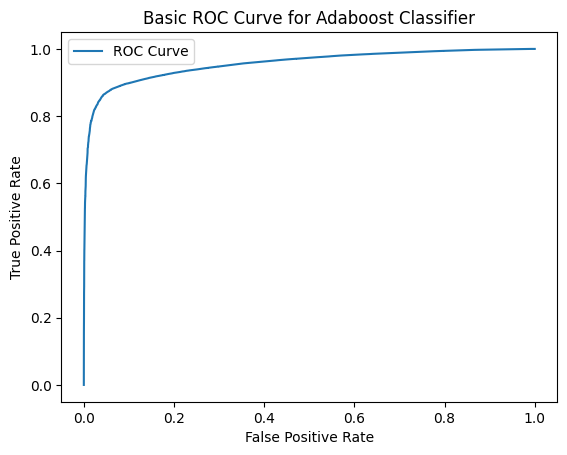

In [35]:
y_prob_abc_basic = abc_basic.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_abc_basic)
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Basic ROC Curve for Adaboost Classifier')
plt.legend()
plt.show()

In [36]:
auc_score = roc_auc_score(y_test, y_prob_abc_basic)
print(f'Basic AUC Score for Adaboost Classifier: {auc_score}')

Basic AUC Score for Adaboost Classifier: 0.9560534762984939


Here at the begining we have 0.95605 AUC Score

2. Hyper Parameter Tuning for Adaboost Classifier

In [37]:
"""
abc_parameters ={
    "n_estimators" : [100,250,500,1000,10000],
    "learning_rate" : [0.01, 0.025, 0.05, 0.075, 0.1, 0.25,0.5]
}
abc_grid = GridSearchCV(abc_basic, abc_parameters, cv = 10, n_jobs= -2)
abc_grid.fit(X_train, y_train)
abc_grid.best_params_
"""

'\nabc_parameters ={ \n    "n_estimators" : [100,250,500,1000,10000],\n    "learning_rate" : [0.01, 0.025, 0.05, 0.075, 0.1, 0.25,0.5]\n}\nabc_grid = GridSearchCV(abc_basic, abc_parameters, cv = 10, n_jobs= -2)\nabc_grid.fit(X_train, y_train)\nabc_grid.best_params_\n'

In [38]:
ABC_final = ABC(random_state = 42 , n_estimators=  10000, learning_rate= 0.25 )
ABC_final.fit(X_train, y_train)
ABC_final_y_pred = ABC_final.predict(X_test)
print(classification_report(y_test,ABC_final_y_pred))

              precision    recall  f1-score   support

           0       0.41      0.91      0.56     15240
           1       0.99      0.90      0.94    194475

    accuracy                           0.90    209715
   macro avg       0.70      0.90      0.75    209715
weighted avg       0.95      0.90      0.91    209715



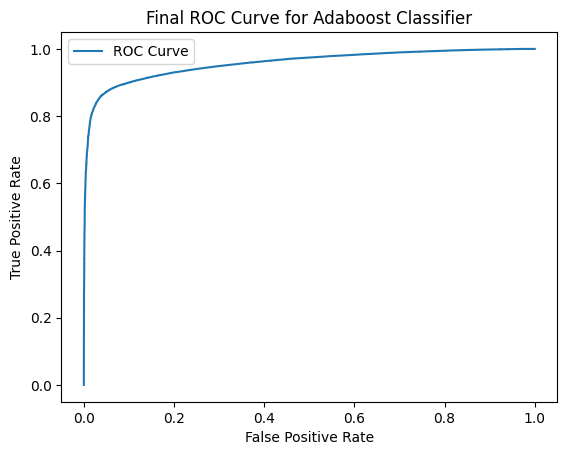

In [39]:
y_prob_abc_final = ABC_final.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_abc_final)
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Final ROC Curve for Adaboost Classifier')
plt.legend()
plt.show()

In [40]:
auc_score = roc_auc_score(y_test, y_prob_abc_final)
print(f'Final AUC Score for Adaboost Classifier: {auc_score}')

Final AUC Score for Adaboost Classifier: 0.957244575796132


We increased our AUC Score to 0.95724 from 0.95605. Random Forest algorithm is still slightly better for our model

* Gradient Boosting Machine (GBM) Classifier

1. GBM Basic

In [41]:
GBM_basic = GBM(random_state = 42)
GBM_basic.fit(X_train,y_train)
GBM_basic_y_pred = GBM_basic.predict(X_test)
print(classification_report(y_test,GBM_basic_y_pred))

              precision    recall  f1-score   support

           0       0.38      0.95      0.54     15240
           1       1.00      0.88      0.93    194475

    accuracy                           0.88    209715
   macro avg       0.69      0.91      0.74    209715
weighted avg       0.95      0.88      0.91    209715



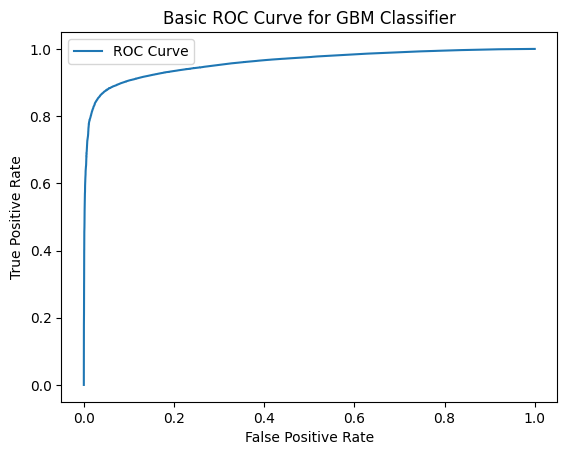

In [42]:
y_prob_gbm_basic = GBM_basic.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_gbm_basic)
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Basic ROC Curve for GBM Classifier')
plt.legend()
plt.show()

In [43]:
auc_score = roc_auc_score(y_test, y_prob_gbm_basic)
print(f'Basic AUC Score for Gradient Boosting Machine Classifier: {auc_score}')

Basic AUC Score for Gradient Boosting Machine Classifier: 0.9597780124428141


0.95977 score without Hyper Parameter Tuning! This is our the best score

2. Hyper Parameter Tuning For GBM

In [44]:
"""gbm_params = {
  "max_depth"  : [2,3,5,6,8],
  "learning_rate": [0.01, 0.5, 0.1, 0.25, 0.5],
  "n_estimators" : [100, 250, 750,1000]

}
GBM_grid = GridSearchCV(GBM_basic,gbm_params, cv = 10, n_jobs = -2)
GBM_grid.fit(X_train, y_train)
GBM_grid.best_params_

"""

'gbm_params = {\n  "max_depth"  : [2,3,5,6,8],\n  "learning_rate": [0.01, 0.5, 0.1, 0.25, 0.5],\n  "n_estimators" : [100, 250, 750,1000]\n    \n}\nGBM_grid = GridSearchCV(GBM_basic,gbm_params, cv = 10, n_jobs = -2)\nGBM_grid.fit(X_train, y_train)\nGBM_grid.best_params_\n\n'

In [45]:
GBM_final = GBM(learning_rate= 0.1, max_depth = 3 , n_estimators= 100,  random_state= 42)
GBM_final.fit(X_train,y_train)
GBM_final_y_pred = GBM_final.predict(X_test)
print(classification_report(y_test,GBM_final_y_pred))

              precision    recall  f1-score   support

           0       0.38      0.95      0.54     15240
           1       1.00      0.88      0.93    194475

    accuracy                           0.88    209715
   macro avg       0.69      0.91      0.74    209715
weighted avg       0.95      0.88      0.91    209715



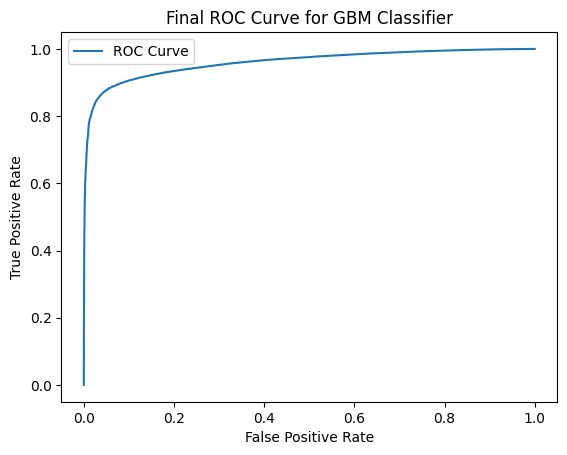

In [46]:
y_prob_gbm_final = GBM_final.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_gbm_final)
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Final ROC Curve for GBM Classifier')
plt.legend()
plt.show()

In [47]:
auc_score = roc_auc_score(y_test, y_prob_gbm_final)
print(f'Final AUC Score for GBM Classifier: {auc_score}')

Final AUC Score for GBM Classifier: 0.9597780124428141


**Here despite best_params_ produces different outputs; for our model basic values (max_depth = 3 and n_estimators = 100) produced better AUC score for our model. Because of AUC score and ROC Curve is suitable for Medical data; we adjusted parameters for AUC Score**

* eXtreme Gradient Boosting Classifier (XGBoost)

1. Basic XGBoost

In [48]:
xgb_basic = xgb.XGBClassifier(random_state = 42,cv=10)
xgb_basic.fit(X_train,y_train)
xgb_basic_y_pred = xgb_basic.predict(X_test)
print(classification_report(y_test,xgb_basic_y_pred))

              precision    recall  f1-score   support

           0       0.38      0.95      0.54     15240
           1       1.00      0.88      0.93    194475

    accuracy                           0.88    209715
   macro avg       0.69      0.92      0.74    209715
weighted avg       0.95      0.88      0.90    209715



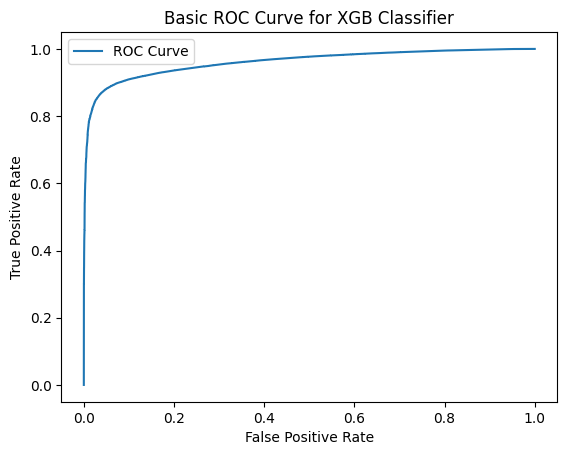

In [49]:
y_prob_xgb_basic = xgb_basic.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_xgb_basic)
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Basic ROC Curve for XGB Classifier')
plt.legend()
plt.show()

In [50]:
auc_score = roc_auc_score(y_test, y_prob_xgb_basic)
print(f'Basic AUC Score for XGB Classifier: {auc_score}')

Basic AUC Score for XGB Classifier: 0.9608104238850205


0.96081! This is the our best score

Hyper Parameter Tuning for XGBoost

In [51]:
"""xgb_params = {
    "learning_rate" : [0.01, 0.05, 0.075, 0.1,0.25],
    "n_estimators": [100,250,500,750,1000],
    "max_depth": [3,4,5,8]

}
xgb_grid = GridSearchCV(xgb_basic, xgb_params, n_jobs = -2)
xgb_grid.fit(X_train,y_train)
xgb_grid.best_params_
"""

'xgb_params = {\n    "learning_rate" : [0.01, 0.05, 0.075, 0.1,0.25],\n    "n_estimators": [100,250,500,750,1000],\n    "max_depth": [3,4,5,8]\n    \n}\nxgb_grid = GridSearchCV(xgb_basic, xgb_params, n_jobs = -2)\nxgb_grid.fit(X_train,y_train)\nxgb_grid.best_params_\n'

In [52]:
xgb_final = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 8, n_estimators = None, random_state = 42,
                              n_jobs = -2,tree_method = "exact",importance_type = "total_gain",
                              eval_metric="auc",cv = 10)
xgb_final.fit(X_train,y_train)
xgb_final_pred = xgb_final.predict(X_test)
print(classification_report(y_test,xgb_final_pred))

              precision    recall  f1-score   support

           0       0.38      0.95      0.54     15240
           1       1.00      0.88      0.93    194475

    accuracy                           0.88    209715
   macro avg       0.69      0.92      0.74    209715
weighted avg       0.95      0.88      0.90    209715



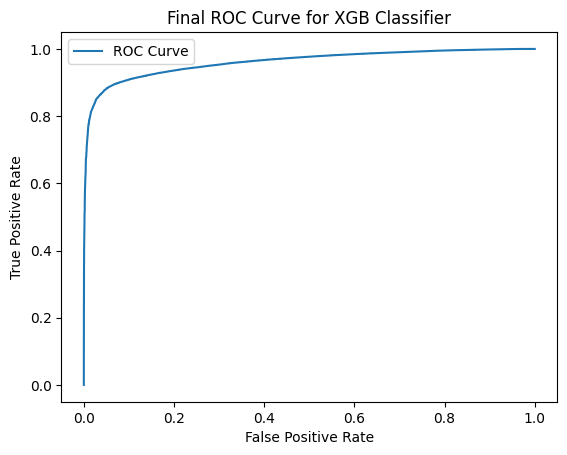

In [53]:
y_prob_xgb_final = xgb_final.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_xgb_final)
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Final ROC Curve for XGB Classifier')
plt.legend()
plt.show()

In [54]:
auc_score = roc_auc_score(y_test, y_prob_xgb_final)
print(f'Final AUC Score for XGB Classifier: {auc_score}')

Final AUC Score for XGB Classifier: 0.960877690086271


**In this situation we couldn't progress a lot with best_params_ method. However we obtained our the best result with XGBoost. 0.96087**

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

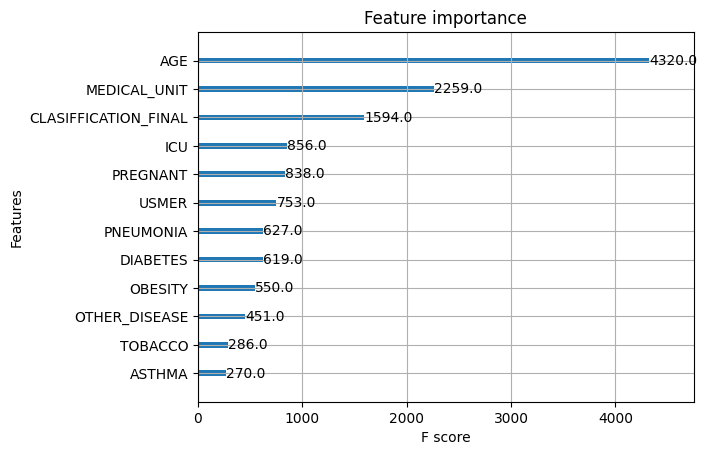

In [55]:
xgb.plot_importance(xgb_final)

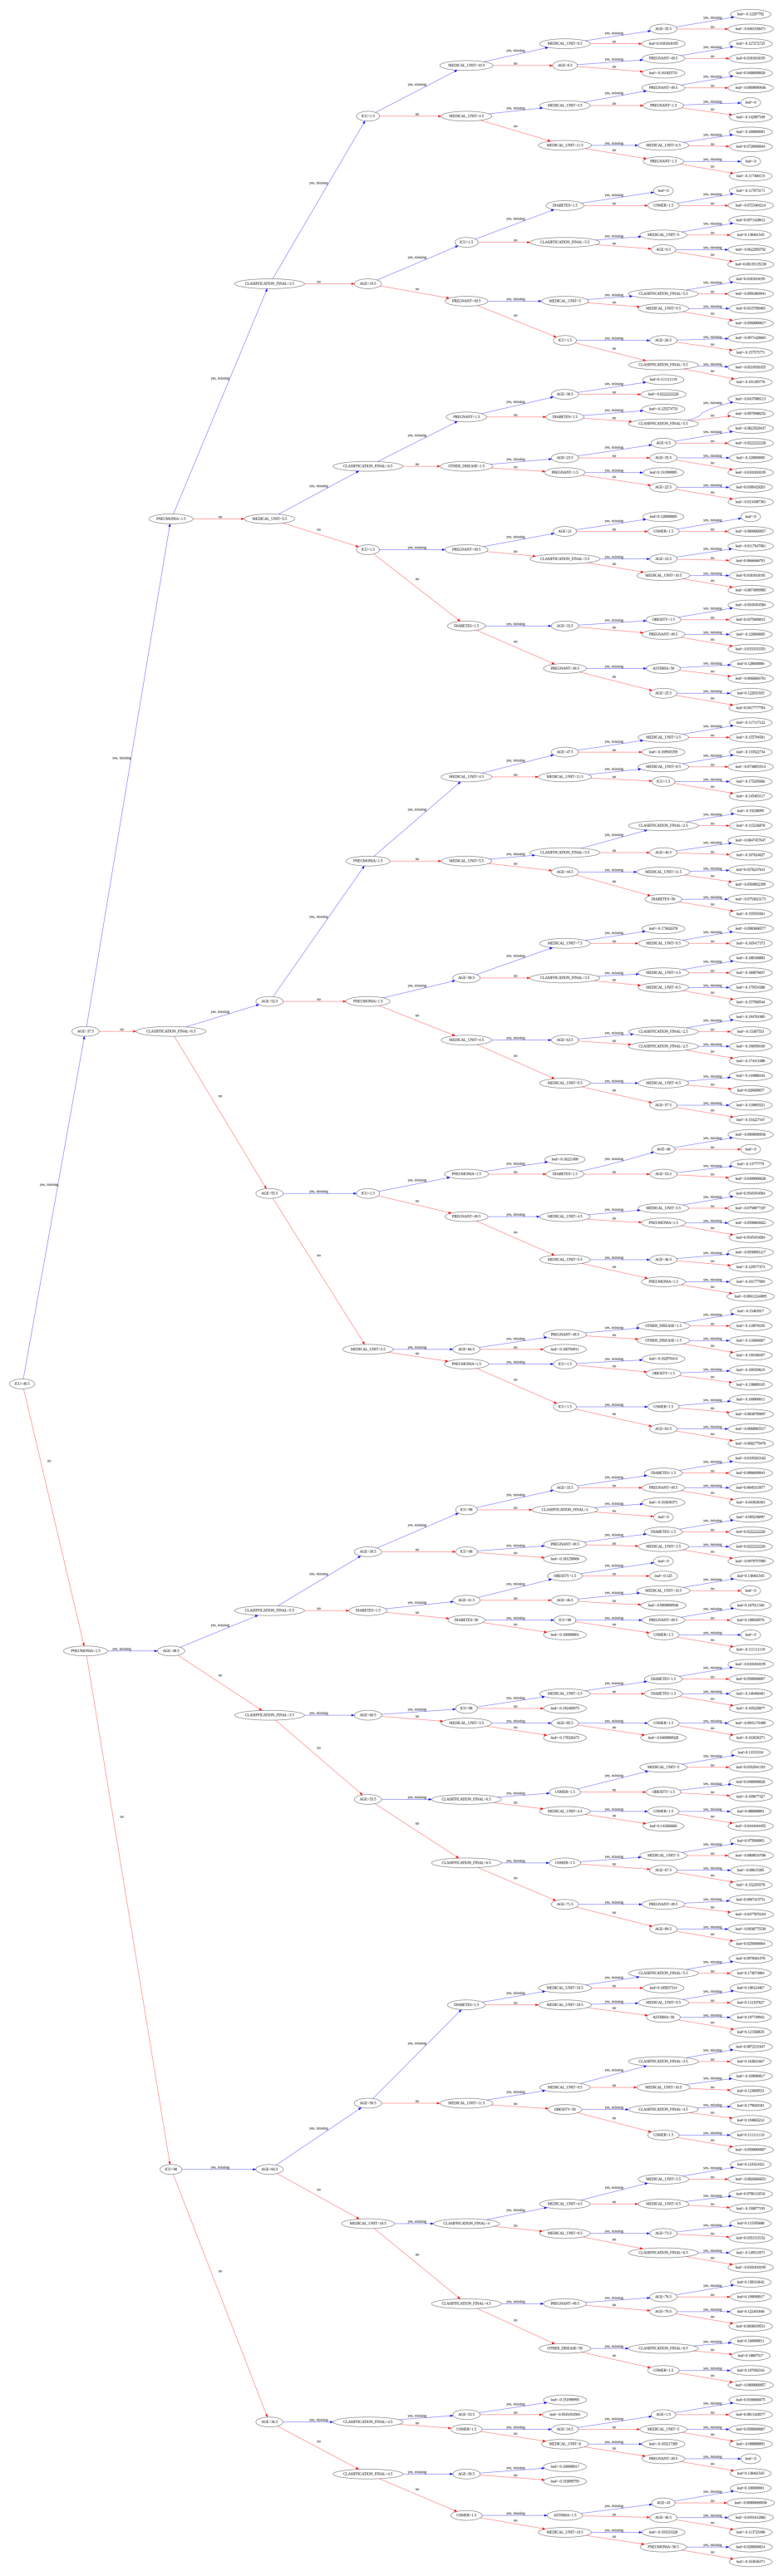

In [56]:
fig, ax = plt.subplots(figsize=(200, 40))
xgb.plot_tree(xgb_final, num_trees=0, ax=ax, rankdir='LR')
plt.show()

* Conclusion

**In this kernel we tried to model Covid 19 data with using different Tree Based Models.We transformed the Date column with a flag column, we eliminated corrolated columns and used random undersampling method for balanced dataset. Also with the algorithm which provides the biggest AUC Score, we saw feaeture importances and decision tree graph. Age, medical unit and classification final features are relatively more important features then others.**